## lhe 에서 b 찾아와서 실제 ak4에 해당하는거 찾기
### 그전에 ak4 갯수 몇갠지 대충 보기 
## 그리고 btagger 결과랑 잘 맞는지


104
[2.18e+03, 3.22e+03, 2.13e+03, 2.17e+03, ..., 2.43e+03, 3.34e+03, 2.81e+03]
[np.int64(2), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(3), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(0), np.int64(3), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(3), np.int64(0), np.int64(0), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(3), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(3), np.int64(3), np.int64(

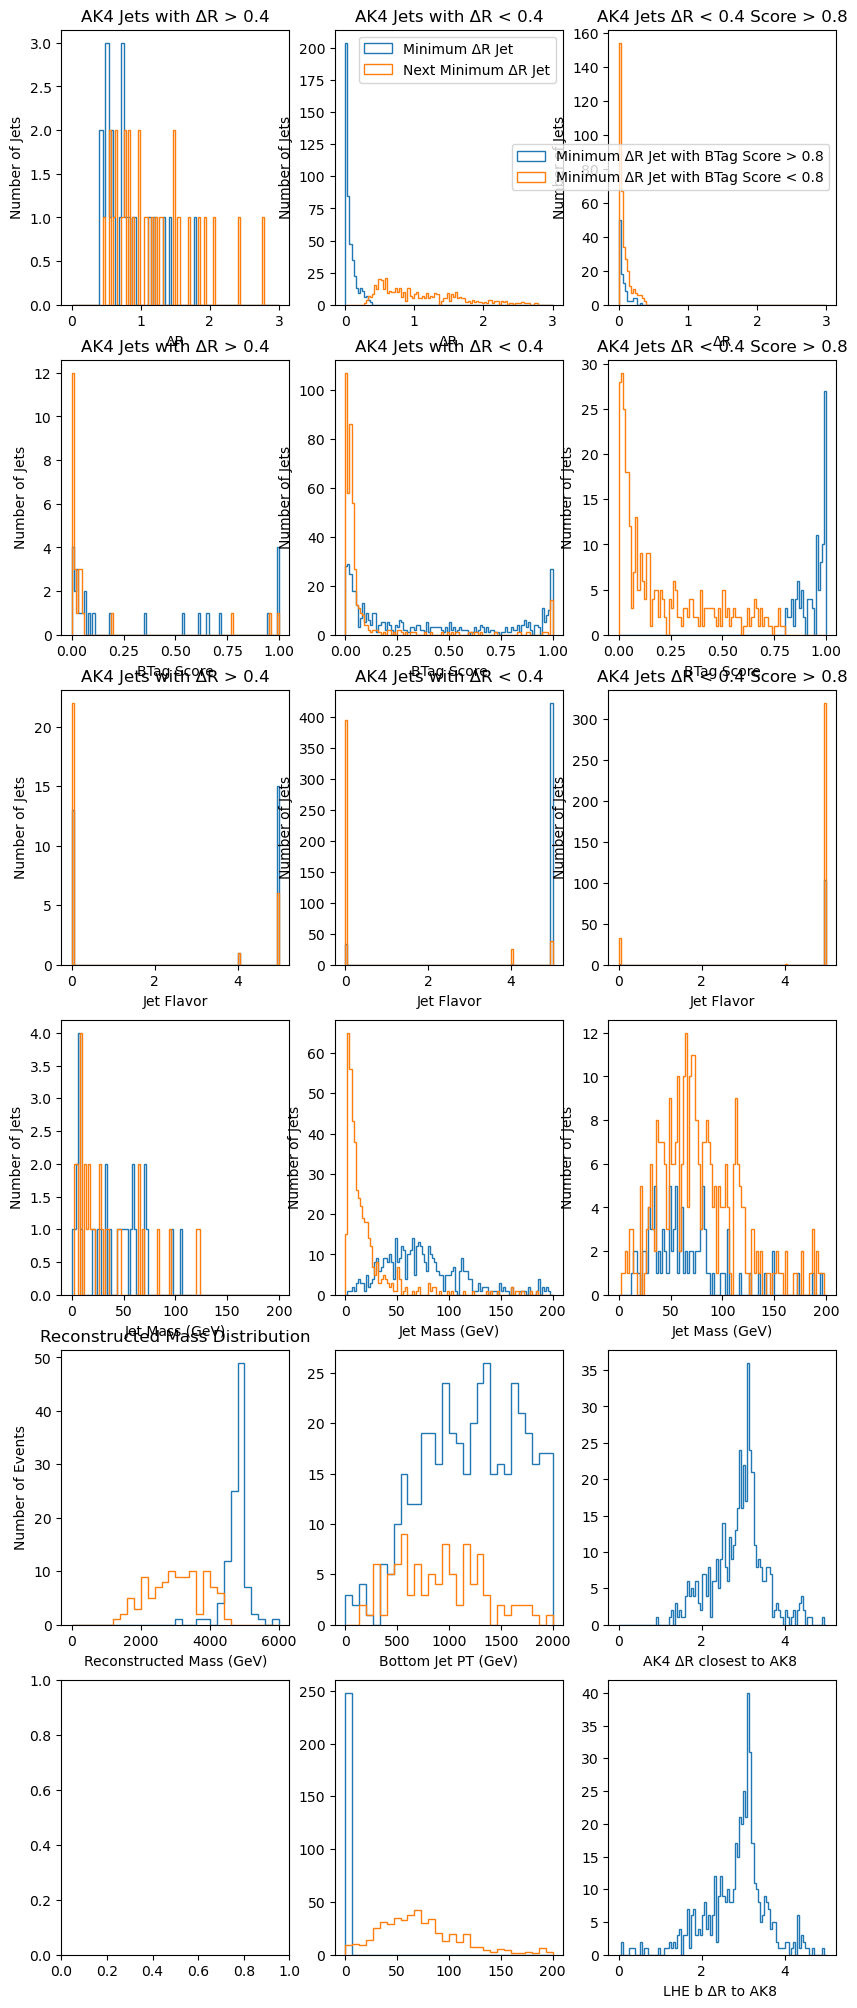

In [ ]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

sample = "/data6/Users/snuintern1/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]
keys = events.keys()


lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()
lhe_status = events["LHEPart_status"].array()

ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

gen_pdgid = events["GenPart_pdgId"].array()
gen_pt = events["GenPart_pt"].array()
gen_eta = events["GenPart_eta"].array()
gen_phi = events["GenPart_phi"].array()

def delta_phi(phi1, phi2):
    d = phi1 - phi2
    # wrap to [-π, +π]
    return (d + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = delta_phi(phi1, phi2)
    return np.sqrt(d_eta**2 + d_phi**2)

# mask 
bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
bottom_eta = lhe_eta[bottom_mask]
bottom_phi = lhe_phi[bottom_mask]
bottom_pt = lhe_pt[bottom_mask]
bottom_mass = lhe_mass[bottom_mask]

topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
top_eta = gen_eta[topmask]
top_phi1 = gen_phi[topmask]

bottompt = bottom_pt[:, 1]#bottom quark 1 = WR* mother
bottometa = bottom_eta[:, 1]
bottomphi = bottom_phi[:, 1]
bottommass = bottom_mass[:, 1]

muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
muon_pt = lhe_pt[muon_mask]
muon_eta = lhe_eta[muon_mask]
muon_phi = lhe_phi[muon_mask]
muon_mass = lhe_mass[muon_mask]

n_mother_muon_mass = muon_mass[:,0] # muon 1 = WR* mother
n_mother_muon_pt = muon_pt[:,0] # muon 1 = WR* mother
n_mother_muon_eta = muon_eta[:,0]
n_mother_muon_phi = muon_phi[:,0]

WR_mother_muon_mass = muon_mass[:,1] # muon 2 = WR* mother
WR_mother_muon_pt = muon_pt[:,1] # muon 2 = WR* mother
WR_mother_muon_eta = muon_eta[:,1]
WR_mother_muon_phi = muon_phi[:,1]  
#####
dr_list_4u = []
idx_list_4u = []
tag_list_4u = [] ## for minimum ΔR jet
flavor_list_4u = [] ## for minimum ΔR jet
mass_list_4u = [] ## for minimum ΔR jet

dr_next_4u = []
idx_next_4u = []
tag_next_4u = [] ## for next minimum ΔR jet
flavor_next_4u = [] ## for next minimum ΔR jet
mass_next_4u = [] ## for next minimum ΔR jet
######
dr_list_4d = []
idx_list_4d = []
tag_list_4d = [] ## for minimum ΔR jet
flavor_list_4d = [] ## for minimum ΔR jet
mass_list_4d = [] ## for minimum ΔR jet

dr_next_4d = []
idx_next_4d = []
tag_next_4d = [] ## for next minimum ΔR jet
flavor_next_4d = [] ## for next minimum ΔR jet
mass_next_4d = [] ## for next minimum ΔR jet

dr_list_4d_btag = []
idx_list_4d_btag = []
tag_list_4d_btag = [] ## for minimum ΔR jet
flavor_list_4d_btag = [] ## for minimum ΔR jet
mass_list_4d_btag = [] ## for minimum ΔR jet

dr_list_4d_ntag = []
idx_list_4d_ntag = []
tag_list_4d_ntag = [] ## for minimum ΔR jet
flavor_list_4d_ntag = [] ## for minimum ΔR jet
mass_list_4d_ntag = [] ## for minimum ΔR jet

dr_next_4d_btag = []
idx_next_4d_btag = []
tag_next_4d_btag = [] ## for next minimum ΔR jet
flavor_next_4d_btag = [] ## for next minimum ΔR jet
mass_next_4d_btag = [] ## for next minimum ΔR jet

##ΔR distribution with ak4 and ak8 jet 
dr_ak8_ak4_closet = []
dr_ak8_ak4_next = []
dr_b_ak8_closest = []

N_reco_masss = []
bottompts = []
real_mass = []

ak4_mass_closest = []
for i in range(len(bottompt)):
        if (len(ak4_mass[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        top_etas = top_eta[i][0]
        top_phi = top_phi1[i][0]
        delta_etas = fatjet_eta[i] - top_etas
        delta_phis = fatjet_phi[i] -top_phi 
        delta_phis = (delta_phis + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_jet = np.sqrt(delta_etas**2 + delta_phis**2)

        

        if ((len(dr) >0 ) and len(dr_jet) > 0):
            idx_ak8 = np.argsort(dr_jet)[0] ## top 과 제일 가까운 fatjet
            idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
            next_idx = np.argsort(dr)[1] ## bottom과 두번째로 가까운 ak4 jet
            r = dr[idx]
            #print(fatjet_eta[i][idx_ak8], bottometa[i])
            deta_b_ak8 = fatjet_eta[i][idx_ak8] - bottometa[i]
            dphi_b_ak8 = fatjet_phi[i][idx_ak8] - bottomphi[i]
            dphi_b_ak8 = (dphi_b_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
            dr_b_ak8 = np.sqrt(deta_b_ak8**2 + dphi_b_ak8**2)
            dr_b_ak8_closest.append(dr_b_ak8)
            #ΔR between bottom ak4 jet and top fatjet
            delta_eta_b_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i]
            delta_phi_b_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i]
            delta_phi_b_ak8 = (delta_phi_b_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
            dr_ak4_ak8 = np.sqrt(delta_eta_b_ak8**2 + delta_phi_b_ak8**2)

            ak4_mass_closest.append(ak4_mass[i][idx]) 
            if dr_b_ak8 > 1.2: 
                if r > 0.4: 
                    idx_list_4u.append(idx)
                    dr_list_4u.append(dr[idx])
                    idx_next_4u.append(next_idx)
                    dr_next_4u.append(dr[next_idx])
                    ## flavor , tagger score check
                
                    tag_score = btag[i][idx]
                    tag_list_4u.append(tag_score)
                    flavor = ak4_flavor[i][idx]
                    flavor_list_4u.append(flavor)
                    tag_next_score = btag[i][next_idx]
                    tag_next_4u.append(tag_next_score)
                    flavor_next = ak4_flavor[i][next_idx]
                    flavor_next_4u.append(flavor_next)
                    mass_list_4u.append(ak4_mass[i][idx])
                    mass_next_4u.append(ak4_mass[i][next_idx])
                if r < 0.4: 
                    idx_list_4d.append(idx)
                    dr_list_4d.append(dr[idx])
                    idx_next_4d.append(next_idx)
                    dr_next_4d.append(dr[next_idx])
                    ## flavor , tagger score check
                    tag_score = btag[i][idx]
                    tag_next_score = btag[i][next_idx]
                    flavor =  ak4_flavor[i][idx]
                    flavor_next = ak4_flavor[i][next_idx]
                    tag_list_4d.append(tag_score)
                    flavor_list_4d.append(flavor)
                    tag_next_4d.append(tag_next_score)
                    flavor_next_4d.append(flavor_next)
                    mass_list_4d.append(ak4_mass[i][idx])
                    mass_next_4d.append(ak4_mass[i][next_idx])

                    dr_ak8_ak4_closet.append(dr_ak4_ak8[idx])
                    dr_ak8_ak4_next.append(dr_ak4_ak8[next_idx])

                    if tag_score > 0.8: # tag score up 0.8
                        idx_list_4d_btag.append(idx)
                        dr_list_4d_btag.append(dr[idx])
                        tag_list_4d_btag.append(tag_score)
                        flavor = ak4_flavor[i][idx]
                        flavor_list_4d_btag.append(flavor)
                        mass_list_4d_btag.append(ak4_mass[i][idx])

                        top_mass = vector.array({"pt": fatjet_pt[i][idx_ak8],
                                                "eta": fatjet_eta[i][idx_ak8],
                                                "phi": fatjet_phi[i][idx_ak8],
                                                "mass": fatjet_mass[i][idx_ak8]})
                        bottom_mass = vector.array({"pt": ak4_mass[i][idx],
                                                "eta": ak4_eta[i][idx],
                                                "phi": ak4_phi[i][idx],
                                                "mass":ak4_mass[i][idx]})
                        n_mother_muon = vector.array({"pt": n_mother_muon_pt[i],
                                                "eta": n_mother_muon_eta[i],
                                                "phi": n_mother_muon_phi[i],
                                                "mass": n_mother_muon_mass[i]})
                        WR_mother_muon = vector.array({"pt": WR_mother_muon_pt[i],
                                                "eta": WR_mother_muon_eta[i],
                                                "phi": WR_mother_muon_phi[i],
                                                "mass": WR_mother_muon_mass[i]})
                        real_bottom_mass = vector.array({"pt": bottompt[i],
                                                "eta": bottometa[i],
                                                "phi": bottomphi[i],
                                                "mass": bottommass[i]})
                        N_reco_mass = (top_mass + bottom_mass+n_mother_muon).mass
                        real_reco_mass = (top_mass + real_bottom_mass+n_mother_muon ).mass
                        real_mass.append(real_reco_mass)
                        N_reco_masss.append(N_reco_mass)
                        bottompts.append(ak4_mass[i][idx])
                        
                    if tag_score < 0.8:    # dr < 0.4 but tag score down 0.8
                        dr_list_4d_ntag.append(dr[idx])
                        tag_score = btag[i][idx]
                        tag_list_4d_ntag.append(tag_score)
                        flavor = ak4_flavor[i][idx]
                        flavor_list_4d_ntag.append(flavor)
                        mass_list_4d_ntag.append(ak4_mass[i][idx])
                    
                ## ak8 안에 bottom jet이 있으면 탈락 


            
            

            

N_reco_masss = ak.flatten(N_reco_masss)
real_mass = ak.flatten(real_mass)
fig , axs = plt.subplots(6, 3 , figsize=(10, 25))
axs[0,0].hist(dr_list_4u, bins=100, range=(0, 3), histtype='step', label='Minimum ΔR Jet')
axs[0,0].hist(dr_next_4u, bins=100, range=(0, 3), histtype='step', label='Next Minimum ΔR Jet')
axs[0,0].set_xlabel('ΔR')
axs[0,0].set_ylabel('Number of Jets')
axs[0,0].set_title('AK4 Jets with ΔR > 0.4')
axs[0,1].hist(dr_list_4d, bins=100, range=(0, 3), histtype='step', label='Minimum ΔR Jet')
axs[0,1].hist(dr_next_4d, bins=100, range=(0, 3), histtype='step', label='Next Minimum ΔR Jet')
axs[0,1].set_xlabel('ΔR')
axs[0,1].set_ylabel('Number of Jets')
axs[0,1].set_title('AK4 Jets with ΔR < 0.4')
axs[0,2].hist(dr_list_4d_btag, bins=100, range=(0, 3), histtype='step', label='Minimum ΔR Jet with BTag Score > 0.8')
axs[0,2].hist(dr_list_4d_ntag, bins=100, range=(0, 3), histtype='step', label='Minimum ΔR Jet with BTag Score < 0.8')
axs[0,2].set_xlabel('ΔR')
axs[0,2].set_ylabel('Number of Jets')
axs[0,2].set_title('AK4 Jets ΔR < 0.4 Score > 0.8')
axs[1,0].hist(tag_list_4u, bins=100, range=(0, 1), histtype='step', label='BTag Score')
axs[1,0].hist(tag_next_4u, bins=100, range=(0, 1), histtype='step', label='Next BTag Score')
axs[1,0].set_xlabel('BTag Score')
axs[1,0].set_ylabel('Number of Jets')
axs[1,0].set_title('AK4 Jets with ΔR > 0.4')
axs[1,1].hist(tag_list_4d, bins=100, range=(0, 1), histtype='step', label='BTag Score')
axs[1,1].hist(tag_next_4d, bins=100, range=(0, 1), histtype='step', label='Next BTag Score')
axs[1,1].set_xlabel('BTag Score')
axs[1,1].set_ylabel('Number of Jets')
axs[1,1].set_title('AK4 Jets with ΔR < 0.4')
axs[1,2].hist(tag_list_4d_btag, bins=100, range=(0, 1), histtype='step', label='BTag Score')
axs[1,2].hist(tag_list_4d_ntag, bins=100, range=(0, 1), histtype='step', label='Next BTag Score')
axs[1,2].set_xlabel('BTag Score')
axs[1,2].set_ylabel('Number of Jets')
axs[1,2].set_title('AK4 Jets ΔR < 0.4 Score > 0.8')
axs[2,0].hist(flavor_list_4u, bins=100, range=(0, 5), histtype='step', label='Jet Flavor')
axs[2,0].hist(flavor_next_4u, bins=100, range=(0, 5), histtype='step', label='Next Jet Flavor')
axs[2,0].set_xlabel('Jet Flavor')
axs[2,0].set_ylabel('Number of Jets')
axs[2,0].set_title('AK4 Jets with ΔR > 0.4')
axs[2,1].hist(flavor_list_4d, bins=100, range=(0, 5), histtype='step', label='Jet Flavor')
axs[2,1].hist(flavor_next_4d, bins=100, range=(0, 5), histtype='step', label='Next Jet Flavor')
axs[2,1].set_xlabel('Jet Flavor')
axs[2,1].set_ylabel('Number of Jets')
axs[2,1].set_title('AK4 Jets with ΔR < 0.4')
axs[2,2].hist(flavor_list_4d_btag, bins=100, range=(0, 5), histtype='step', label='Jet Flavor')
axs[2,2].hist(flavor_list_4d_ntag, bins=100, range=(0, 5), histtype='step', label='Next Jet Flavor')
axs[2,2].set_xlabel('Jet Flavor')
axs[2,2].set_ylabel('Number of Jets')
axs[2,2].set_title('AK4 Jets ΔR < 0.4 Score > 0.8')
axs[3,0].hist(mass_list_4u, bins=100, range=(0, 200), histtype='step', label='Jet Mass')
axs[3,0].hist(mass_next_4u, bins=100, range=(0, 200), histtype='step', label='Next Jet Mass')
axs[3,0].set_xlabel('Jet Mass (GeV)')
axs[3,0].set_ylabel('Number of Jets')
axs[3,1].hist(mass_list_4d, bins=100, range=(0, 200), histtype='step', label='Jet Mass')
axs[3,1].hist(mass_next_4d, bins=100, range=(0, 200), histtype='step', label='Next Jet Mass')
axs[3,1].set_xlabel('Jet Mass (GeV)')   
axs[3,1].set_ylabel('Number of Jets')
axs[3,2].hist(mass_list_4d_btag, bins=100, range=(0, 200), histtype='step', label='Jet Mass')
axs[3,2].hist(mass_list_4d_ntag, bins=100, range=(0, 200), histtype='step', label='Next Jet Mass')
axs[3,2].set_xlabel('Jet Mass (GeV)')
axs[3,2].set_ylabel('Number of Jets')
axs[4,0].hist(real_mass, bins=30, range=(0, 6000), histtype='step', label='Real Reconstructed Mass')
axs[4,0].hist(N_reco_masss, bins=30, range=(0, 6000), histtype='step', label='Reconstructed Mass')
axs[4,0].set_xlabel('Reconstructed Mass (GeV)')
axs[4,0].set_ylabel('Number of Events')
axs[4,0].set_title('Reconstructed Mass Distribution')
axs[4,1].hist(bottompt, bins=30, range=(0, 2000), histtype='step', label='Bottom Jet PT from LHE')
axs[4,1].hist(bottompts, bins=30, range=(0, 2000), histtype='step', label='Bottom Jet PT')
axs[4,1].set_xlabel('Bottom Jet PT (GeV)')
axs[4,2].hist(dr_ak8_ak4_closet, bins=100, range=(0, 5), histtype='step', label='ΔR between AK8 and Closest AK4 Jet')
#axs[4,2].hist(dr_ak8_ak4_next, bins=100, range=(0, 5), histtype='step', label='ΔR between AK8 and Next Closest AK4 Jet')
axs[4,2].set_xlabel('AK4 ΔR closest to AK8 ')
axs[5,2].hist(dr_b_ak8_closest, bins=100, range=(0, 5), histtype='step', label='ΔR between Bottom and Closest AK8 Jet')
axs[5,2].set_xlabel('LHE b ΔR to AK8 ')
axs[5,1].hist(bottommass , bins=30, range=(0, 200), histtype='step', label='Bottom Mass from LHE')
axs[5,1].hist(ak4_mass_closest, bins=30, range=(0, 200), histtype='step', label='Closest AK4 Jet Mass')
axs[0,1].legend()
axs[0,2].legend()
#일단 제일 작은 ΔR을 갖는 jet를 찾고 그게 ak8 보다 1.2 이상 벌어져야 함 . 
## 두번째 히스토 그램은 두번째로 큰 r이 유효할 수도 있는지 확인 하는거 
## 세번째 히스토그램은 signal b와 0.4이내에 있는 btag 0.8 이상과 이하 비교
print(len(dr_list_4d_btag)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있고 btag 0.8 이상인 것 )
print(N_reco_masss)
print(idx_list_4d_btag)

## b pt 큰 순서대로 두 세개 보기 

[[1.14e+03, 80.5, 1.1e+03, 80.5], [...], ..., [210, 393, 22.3, 71.5, 64.8, 393]]
[[80.5, 1.14e+03], [969, 972], [324, 137], ..., [...], [585, 480], [408, 207]]
[[1.59e+03, 1.18e+03, 1.16e+03, 101, 25.3], ..., [1.1e+03, 838, ..., 15.6]]
[[1.16e+03], [1.34e+03, 926], [...], ..., [1.39e+03, 513], [1.1e+03, 89.5, 81]]


/tmp/ipykernel_2123738/903705360.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


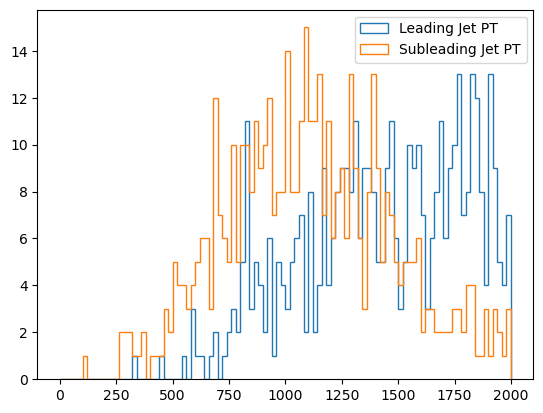

In [ ]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

sample = "/data6/Users/snuintern1/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-2500_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]
keys = events.keys()


lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()
lhe_status = events["LHEPart_status"].array()

ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_mass = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

gen_pdgid = events["GenPart_pdgId"].array()
gen_pt = events["GenPart_pt"].array()
gen_eta = events["GenPart_eta"].array()
gen_phi = events["GenPart_phi"].array()

gen_topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
gen_top_eta = gen_eta[gen_topmask]
gen_top_phi = gen_phi[gen_topmask]

ak4_leading_eta = ak4_eta[:, 0]  # Leading jet eta
ak4_leading_phi = ak4_phi[:, 0]  # Leading jet phi
ak4_subleading_eta = ak4_eta[:, 1]  # Subleading jet eta
ak4_subleading_phi = ak4_phi[:, 1]  # Subleading jet phi



lhe_bmask = ((lhe_pdgid == 5) | (lhe_pdgid == -5))  # Bottom quark pdgid mask
gen_bmask = ((gen_pdgid == 5) | (gen_pdgid == -5))  # Bottom quark pdgid mask
flavor_mask = (ak4_flavor== 5) 
print(gen_pt[gen_bmask])
print(lhe_pt[bmask])
print(ak4_pt)
print(ak4_pt[flavor_mask])


delta_phi = ak4_leading_phi - gen_top_phi[:,0]  # Leading jet phi - Top eta
delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
delta_eta = ak4_leading_eta - ak4_subleading_eta  # Leading jet eta - Top eta

delta_phi_subleading = ak4_subleading_phi - gen_top_phi[:,0]  # Subleading jet phi - Top eta
delta_phi_subleading = (delta_phi_subleading + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
delta_eta_subleading = ak4_subleading_eta - gen_top_eta[:,0]  # Subleading jet eta - Top eta
dr_leading = np.sqrt(delta_eta**2 - delta_phi**2)
dr_subleading = np.sqrt(delta_eta_subleading**2 + delta_phi_subleading**2)

#plt.hist(dr_leading, bins=100, range=(0, 3), histtype='step', label='Leading Jet ΔR')
#plt.hist(dr_subleading, bins=100, range=(0, 3), histtype='step', label='Subleading Jet ΔR')
plt.legend()
'''
lhe_eta = lhe_eta[lhe_bmask]
lhe_phi = lhe_phi[lhe_bmask]
lhe_eta = lhe_eta[:, 1]
lhe_phi = lhe_phi[:, 1]
## checking the delta R between leading jet and bottom quark
delta_eta_b = ak4_leading_eta - lhe_eta  # Leading jet eta - Bottom eta
delta_phi_b = ak4_leading_phi - lhe_phi  # Leading jet phi - Bottom
delta_phi_b = (delta_phi_b + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
dr_b = np.sqrt(delta_eta_b**2 + delta_phi_b**2)
plt.hist(dr_b, bins=100, range=(0, 5), histtype='step', label='Leading Jet ΔR with Bottom Quark')
plt.xlabel('ΔR')
'''
ak4_leading_pt = ak4_pt[:, 0]  # Leading jet pt
ak4_subleading_pt = ak4_pt[:, 1]  # Subleading jet pt
check_flavor = ak4_flavor[:, 0]  # Leading jet flavor
check_sub_flavor = ak4_flavor[:, 1]  # Subleading jet flavor
#plt.hist(check_flavor, bins=100, range=(0, 5), histtype='step', label='Leading Jet Flavor')
#plt.hist(check_sub_flavor, bins=100, range=(0, 5), histtype='step', label='Subleading Jet Flavor')
#ratio = ak4_leading_pt - ak4_subleading_pt  # Ratio of leading to subleading jet pt
#plt.hist(ratio, bins=100, range=(-1000, 1000), histtype='step', label='Leading/Subleading Jet PT Ratio')
## 반드시 먼저온게 pt가 큰거 확인 


plt.hist(ak4_leading_pt, bins=100, range=(0, 2000), histtype='step', label='Leading Jet PT')
plt.hist(ak4_subleading_pt, bins=100, range=(0, 2000), histtype='step', label='Subleading Jet PT')

plt.legend()
#plt.xlabel('Jet PT (GeV)')



### AK4 어떻게 b AK4 찾을 건지

signal ak4 pt 499
masked signal ak4 pt 355
all ak4 pt 3815
masked all ak4 pt 415


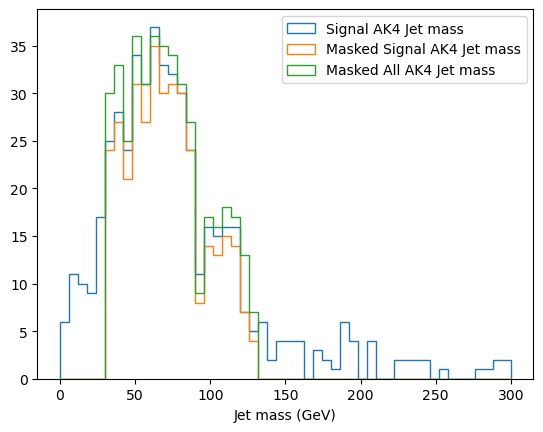

In [107]:
from importlib import import_module
import os
import sys
import argparse
import linecache
import uproot
import vector
import math
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

sample = "/data6/Users/snuintern1/LRSM_tb_channel/SAMPLEPRODUCTION/WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV/Run3Summer22NanoAODv12_WRtoNMutoMuMuTB-HadTop_MWR-5000_MN-4900_13p6TeV_1.root"
file = uproot.open(sample)
events = file["Events"]
keys = events.keys()


lhe_pdgid = events["LHEPart_pdgId"].array()
lhe_pt = events["LHEPart_pt"].array()
lhe_eta = events["LHEPart_eta"].array()
lhe_phi = events["LHEPart_phi"].array()
lhe_mass = events["LHEPart_mass"].array()
lhe_status = events["LHEPart_status"].array()

ak4_eta = events["Jet_eta"].array()
ak4_phi = events["Jet_phi"].array()
ak4_pt = events["Jet_pt"].array()
ak4_flavor = events["Jet_hadronFlavour"].array()
ak4_mass = events["Jet_mass"].array()
btag = events["Jet_btagPNetB"].array()

## Fatjet 
fatjet_pt = events["FatJet_pt"].array()
fatjet_eta = events["FatJet_eta"].array()
fatjet_phi = events["FatJet_phi"].array()
fatjet_mass = events["FatJet_mass"].array()

gen_pdgid = events["GenPart_pdgId"].array()
gen_pt = events["GenPart_pt"].array()
gen_eta = events["GenPart_eta"].array()
gen_phi = events["GenPart_phi"].array()

def delta_phi(phi1, phi2):
    d = phi1 - phi2
    # wrap to [-π, +π]
    return (d + np.pi) % (2*np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = delta_phi(phi1, phi2)
    return np.sqrt(d_eta**2 + d_phi**2)

# mask 
bottom_mask = (lhe_pdgid == 5) | (lhe_pdgid == -5)
bottom_eta = lhe_eta[bottom_mask]
bottom_phi = lhe_phi[bottom_mask]
bottom_pt = lhe_pt[bottom_mask]
bottom_mass = lhe_mass[bottom_mask]

topmask = (gen_pdgid == 6) | (gen_pdgid == -6)
top_eta = gen_eta[topmask]
top_phi1 = gen_phi[topmask]

bottompt = bottom_pt[:, 1]#bottom quark 1 = WR* mother
bottometa = bottom_eta[:, 1]
bottomphi = bottom_phi[:, 1]
bottommass = bottom_mass[:, 1]

muon_mask = (lhe_pdgid == 13) | (lhe_pdgid == -13)
muon_pt = lhe_pt[muon_mask]
muon_eta = lhe_eta[muon_mask]
muon_phi = lhe_phi[muon_mask]
muon_mass = lhe_mass[muon_mask]

n_mother_muon_mass = muon_mass[:,0] # muon 1 = WR* mother
n_mother_muon_pt = muon_pt[:,0] # muon 1 = WR* mother
n_mother_muon_eta = muon_eta[:,0]
n_mother_muon_phi = muon_phi[:,0]

WR_mother_muon_mass = muon_mass[:,1] # muon 2 = WR* mother
WR_mother_muon_pt = muon_pt[:,1] # muon 2 = WR* mother
WR_mother_muon_eta = muon_eta[:,1]
WR_mother_muon_phi = muon_phi[:,1]  
'''
## 1. b score 

bscore = []
a_bscore = []
a_btag_scores = []
for i in range(len(bottompt)):
        if (len(ak4_pt[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        if len(dr) == 0: 
            continue
        idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
        if dr[idx] > 0.4: 
            continue
        btag_score = btag[i][idx]
        bscore.append(btag_score)
        
        mask_flavor = ((ak4_flavor[i] == 5) )# Bottom quark flavor mask
        a_btag_score = btag[i]
        a_btag_score = a_btag_score[mask_flavor]
        a_btag_scores.append(a_btag_score)
        if mask_flavor[idx] == True:  # Check if the jet is a bottom quark
            a_bscore.append(btag_score)
btag_score = ak.flatten(btag)

a_btag_scores = ak.flatten(a_btag_scores)
#plt.hist(btag_score, bins=100, range=(0, 1), histtype='step', label='all BTag Score')
plt.hist(bscore, bins=100, range=(0, 1), histtype='step', label='signal BTag Score')
plt.hist(a_btag_scores, bins=100, range=(0, 1), histtype='step', label='masked all BTag Score')
plt.hist(a_bscore, bins=100, range=(0, 1), histtype='step', label='masked signal BTag Score')
plt.legend()
print("all b tag score ", len(btag_score)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
print("signal Btag score", len(bscore)) ## 500개 중에서 몇개 사용 가능한지 (0.4 이내에 있는 것 )
print("masked all b tag score", len(a_btag_scores)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
print("masked signal B tag score", len(a_bscore)) ## 500개 중에서 몇개 사용 가능한지 (0.4 이내에 있는 것 )

#print(f"Number of BTag Scores: {len(bscore)}")
#print(bscore)

## 2. pt. 
pt_list_sig_ak4 = []
a_pt_list_sig_ak4 = [] # after masking signals 
a_all_ak4_pt = [] #after masking all ak4 jets
for i in range(len(bottompt)):
        if (len(ak4_pt[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        top_etas = top_eta[i][0]
        top_phi = top_phi1[i][0]
        delta_etas = fatjet_eta[i] - top_etas
        delta_phis = fatjet_phi[i] -top_phi 
        delta_phis = (delta_phis + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_jet = np.sqrt(delta_etas**2 + delta_phis**2)

        if len(dr) == 0: 
            continue
        idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
        if dr[idx] > 0.4: 
            continue
        pt_list_sig_ak4.append(ak4_pt[i][idx])


        delta_eta_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i][idx]
        delta_phi_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i][idx]
        delta_phi_ak4_ak8 = (delta_phi_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_ak4_ak8 = np.sqrt(delta_eta_ak4_ak8**2 + delta_phi_ak4_ak8**2)
        drs_ak4_ak8.append(dr_ak4_ak8)
        
        if dr_ak4_ak8 > 1.0: ## delta r mask cut 
            continue

        mask_flavor = ((ak4_flavor[i] == 5) )# Bottom quark flavor mask
        a_all_ak4pt = ak4_pt[i]
        a_all_ak4pt = a_all_ak4pt[mask_flavor]
        a_all_ak4_pt.append(a_all_ak4pt) ## masked all ak4 pt


        if mask_flavor[idx] == True:
            a_pt_list_sig_ak4.append(ak4_pt[i][idx]) ## masked signal ak4 pt



all_ak4_pt = ak.flatten(ak4_pt)
a_all_ak4_pt = ak.flatten(a_all_ak4_pt)
plt.hist(pt_list_sig_ak4, bins=30, range=(0, 3000), histtype='step', label='Signal AK4 Jet PT')
plt.hist(a_pt_list_sig_ak4, bins=30, range=(0, 3000), histtype='step', label='Masked Signal AK4 Jet PT')
#plt.hist(all_ak4_pt, bins=100, range=(0, 3000), histtype='step', label='All AK4 Jet PT')
plt.hist(a_all_ak4_pt, bins=30, range=(0, 3000), histtype='step', label='Masked All AK4 Jet PT')
plt.xlabel('Jet PT (GeV)')
#plt.hist(pt_list_sig_ak4, bins=100, range=(0, 3000), histtype='step', label='AK4 Jet PT')
#plt.hist(all_ak4_pt, bins=100, range=(0, 3000), histtype='step', label='All AK4 Jet PT')
plt.legend()
print("signal ak4 pt", len(pt_list_sig_ak4)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
print("masked signal ak4 pt", len(a_pt_list_sig_ak4)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것
print("all ak4 pt", len(all_ak4_pt)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
print("masked all ak4 pt", len(a_all_ak4_pt)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )

## 3. ΔR between AK4 jet and AK8 jet 

drs_ak4_ak8 = []
drs_all_ak4_ak8 = []
a_drs_ak4_ak8 = [] # after masking signals
a_drs_all_ak4_ak8 = [] # after masking all ak4 jets
for i in range(len(bottompt)):
        if (len(ak4_pt[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        top_etas = top_eta[i][0]
        top_phi = top_phi1[i][0]
        delta_etas = fatjet_eta[i] - top_etas
        delta_phis = fatjet_phi[i] -top_phi 
        delta_phis = (delta_phis + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_jet = np.sqrt(delta_etas**2 + delta_phis**2)

        if len(dr) == 0: 
            continue
        idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
        idx_ak8 = np.argsort(dr_jet)[0] ## top 과 제일 가까운 fatjet
        if dr[idx] > 0.4: 
            continue

        delta_eta_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i][idx]
        delta_phi_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i][idx]
        delta_phi_ak4_ak8 = (delta_phi_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_ak4_ak8 = np.sqrt(delta_eta_ak4_ak8**2 + delta_phi_ak4_ak8**2)
        drs_ak4_ak8.append(dr_ak4_ak8)

        delta_eta_all_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i]
        delta_phi_all_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i]
        delta_phi_all_ak4_ak8 = (delta_phi_all_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_all_ak4_ak8 = np.sqrt(delta_eta_all_ak4_ak8**2 + delta_phi_all_ak4_ak8**2)
        drs_all_ak4_ak8.append(dr_all_ak4_ak8)
        
        mask_flavor = ((ak4_flavor[i] == 5) )# Bottom quark flavor mask
        a_drs_all_ak4_ak8.append(dr_all_ak4_ak8[mask_flavor]) ## masked all ak4 dr
        if mask_flavor[idx] == True:
            a_drs_ak4_ak8.append(dr_ak4_ak8)

drs_all_ak4_ak8 = ak.flatten(drs_all_ak4_ak8)
a_drs_all_ak4_ak8 = ak.flatten(a_drs_all_ak4_ak8)
#plt.hist(drs_all_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between All AK4 and AK8 Jet')
plt.hist(a_drs_all_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='Masked ΔR between All AK4 and AK8 Jet')
plt.hist(drs_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between Closest AK4 and AK8 Jet')
plt.hist(a_drs_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='Masked ΔR between Closest AK4 and AK8 Jet')
plt.xlabel('ΔR between AK4 and AK8 Jet')
#plt.hist(drs_all_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between AK4 and AK8 Jet')
#plt.hist(drs_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between Closest AK4 and AK8 Jet')
plt.legend()        


## 4. flavor 
flavor_ak4 = []

for i in range(len(bottompt)):
        if (len(ak4_pt[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        top_etas = top_eta[i][0]
        top_phi = top_phi1[i][0]
        delta_etas = fatjet_eta[i] - top_etas
        delta_phis = fatjet_phi[i] -top_phi 
        delta_phis = (delta_phis + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_jet = np.sqrt(delta_etas**2 + delta_phis**2)

        if len(dr) == 0: 
            continue
        idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
        if dr[idx] > 0.4: 
            continue
        flavor = ak4_flavor[i][idx]
        flavor_ak4.append(flavor)

ak4_flavor = ak.flatten(ak4_flavor)
plt.hist(flavor_ak4, bins=100, range=(-5, 5), histtype='step', label='AK4 Jet Flavor')
plt.hist(ak4_flavor, bins=100, range=(-5, 5), histtype='step', label='All AK4 Jet Flavor')
plt.legend()
flavor_ak4_num = np.sum(np.array(ak4_flavor) ) ## b jet
print(f"Number of b jets in AK4: {flavor_ak4_num}")


### 가장 효과적인건 mask flavor , b score , pt , ΔR between AK4 and AK8 jet 에 얼마나 영향 주는 지 확인 하기 
mask_flavor = (ak4_flavor == 5) | (ak4_flavor == -5)  # Bottom quark flavor mask

## before mask
bscore = []
pt_list_sig_ak4 = []
drs_ak4_ak8 = []
drs_all_ak4_ak8 = []
# after mask
a_bscore = []
a_pt_list_sig_ak4 = []
a_drs_ak4_ak8 = []
a_drs_all_ak4_ak8 = []
for i in range(len(bottompt)):
        if (len(ak4_pt[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        top_etas = top_eta[i][0]
        top_phi = top_phi1[i][0]
        delta_etas = fatjet_eta[i] - top_etas
        delta_phis = fatjet_phi[i] -top_phi 
        delta_phis = (delta_phis + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_jet = np.sqrt(delta_etas**2 + delta_phis**2)


        if len(dr) == 0: 
            continue
        idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
        idx_ak8 = np.argsort(dr_jet)[0] ## top 과 제일 가까운 fatjet
        if dr[idx] > 0.4: 
            continue
        btag_score = btag[i][idx] ## bscore
        bscore.append(btag_score)
        
        pt_list_sig_ak4.append(ak4_pt[i][idx])
        
        delta_eta_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i][idx]
        delta_phi_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i][idx]
        delta_phi_ak4_ak8 = (delta_phi_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_ak4_ak8 = np.sqrt(delta_eta_ak4_ak8**2 + delta_phi_ak4_ak8**2)
        drs_ak4_ak8.append(dr_ak4_ak8)

        delta_eta_all_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i]
        delta_phi_all_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i]
        delta_phi_all_ak4_ak8 = (delta_phi_all_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_all_ak4_ak8 = np.sqrt(delta_eta_all_ak4_ak8**2 + delta_phi_all_ak4_ak8**2)
        drs_all_awk4_ak8.append(dr_all_ak4_ak8)
        if not mask_flavor[[i][idx]]:  # Check if the jet is a bottom quark
            continue
        btag_score = btag[i][idx] ## bscore
        a_bscore.append(btag_score)
        
        a_pt_list_sig_ak4.append(ak4_pt[i][idx])
        
        delta_eta_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i][idx]
        delta_phi_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i][idx]
        delta_phi_ak4_ak8 = (delta_phi_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_ak4_ak8 = np.sqrt(delta_eta_ak4_ak8**2 + delta_phi_ak4_ak8**2)
        a_drs_ak4_ak8.append(dr_ak4_ak8)

        delta_eta_all_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i]
        delta_phi_all_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i]
        delta_phi_all_ak4_ak8 = (delta_phi_all_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_all_ak4_ak8 = np.sqrt(delta_eta_all_ak4_ak8**2 + delta_phi_all_ak4_ak8**2)
        a_drs_all_ak4_ak8.append(dr_all_ak4_ak8)

drs_all_ak4_ak8 = ak.flatten(drs_all_ak4_ak8)
a_drs_all_ak4_ak8 = ak.flatten(a_drs_all_ak4_ak8)
all_ak4_pt = ak.flatten(ak4_pt)
a_all_ak4_pt = ak.flatten(a_pt_list_sig_ak4)

fig , axs = plt.subplots(4, 3 , figsize=(10, 20))
axs[0,0].hist(drs_all_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between AK4 and AK8 Jet')
axs[0,0].hist(drs_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between Closest AK4 and AK8 Jet')
axs[0,0].hist(a_drs_all_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between AK4 and AK8 Jet after Mask')
axs[0,0].hist(a_drs_ak4_ak8, bins=100, range=(0, 5), histtype='step', label='ΔR between Closest AK4 and AK8 Jet after Mask')
axs[0,0].set_xlabel('ΔR')
axs[0,0].set_ylabel('Number of Jets')

axs[1,0].hist(bscore, bins=100, range=(0, 1), histtype='step', label='BTag Score')
axs[1,0].hist()
axs[1,0].hist(a_bscore, bins=100, range=(0, 1), histtype='step', label='BTag Score after Mask')

'''
## 4.mass
mass_list_sig_ak4 = []
a_mass_list_sig_ak4 = [] # after masking signals 
a_all_ak4_mass = [] #after masking all ak4 jets
for i in range(len(bottompt)):
        if (len(ak4_pt[i]) == 0) or ((bottompt[i]) == False) or (len(top_eta[i]) < 2):
            continue
        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        delta_eta = bottometa[i] - ak4_eta[i]
        delta_phi = bottomphi[i] - ak4_phi[i] 
        delta_phi = (delta_phi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr = np.sqrt(delta_eta**2 + delta_phi**2)

        top_etas = top_eta[i][0]
        top_phi = top_phi1[i][0]
        delta_etas = fatjet_eta[i] - top_etas
        delta_phis = fatjet_phi[i] -top_phi 
        delta_phis = (delta_phis + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_jet = np.sqrt(delta_etas**2 + delta_phis**2)

        if len(dr) == 0: 
            continue
        idx = np.argsort(dr)[0] ## bottom과 제일 가까운 ak4 jet
        #if dr[idx] > 0.4: 
        #    continue
        mass_list_sig_ak4.append(ak4_mass[i][idx])


        delta_eta_ak4_ak8 = fatjet_eta[i][idx_ak8] - ak4_eta[i][idx]
        delta_phi_ak4_ak8 = fatjet_phi[i][idx_ak8] - ak4_phi[i][idx]
        delta_phi_ak4_ak8 = (delta_phi_ak4_ak8 + np.pi) % (2 * np.pi) - np.pi  # wrap to [-π, +π]
        dr_ak4_ak8 = np.sqrt(delta_eta_ak4_ak8**2 + delta_phi_ak4_ak8**2)
        drs_ak4_ak8.append(dr_ak4_ak8)
        
        #if dr_ak4_ak8 > 1.0: ## delta r mask cut 
        #    continue
        if ak4_mass[i][idx] <30 or ak4_mass[i][idx] > 130: ## mass cut
            continue
        mask_flavor = ((ak4_flavor[i] == 5) )# Bottom quark flavor mask
        mask_mass_flavor = (ak4_flavor[i] == 5) & (ak4_mass[i] > 30) & (ak4_mass[i] < 130) # Bottom quark flavor mask and mass cut
        a_all_ak4mass = ak4_mass[i]
        a_all_ak4mass = a_all_ak4mass[mask_mass_flavor]
        a_all_ak4_mass.append(a_all_ak4mass) ## masked all ak4 pt


        if mask_flavor[idx] == True:
            a_mass_list_sig_ak4.append(ak4_mass[i][idx]) ## masked signal ak4 pt



all_ak4_mass = ak.flatten(ak4_mass)
a_all_ak4_mass = ak.flatten(a_all_ak4_mass)
plt.hist(mass_list_sig_ak4, bins=50, range=(0, 300), histtype='step', label='Signal AK4 Jet mass')
plt.hist(a_mass_list_sig_ak4, bins=50, range=(0, 300), histtype='step', label='Masked Signal AK4 Jet mass')
#plt.hist(all_ak4_mass, bins=50, range=(0, 500), histtype='step', label='All AK4 Jet mass')
plt.hist(a_all_ak4_mass, bins=50, range=(0, 300), histtype='step', label='Masked All AK4 Jet mass')
plt.xlabel('Jet mass (GeV)')

plt.legend()
print("signal ak4 pt", len(mass_list_sig_ak4)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
print("masked signal ak4 pt", len(a_mass_list_sig_ak4)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것
print("all ak4 pt", len(all_ak4_mass)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
print("masked all ak4 pt", len(a_all_ak4_mass)) ## 500개 중에서 몇개 사용 가능한지 ( 0.4 이내에 있는 것 )
